# Tutorial: Model a vertical abundance gradient

In this tutorial, we use a public catalog of metallicities of red giant branch (RGB) stars from the [APOGEE surveys](https://www.sdss4.org/surveys/#APOGEE-2) combined with astrometric data from [Gaia](https://www.esa.int/Science_Exploration/Space_Science/Gaia) to fit the vertical ($z$–$v_z$) gradient of [Mg/Fe] for stars near the sun's position in the Milky Way disk. 
We will use astrometric data (sky position, parallax, and proper motion) from the Gaia Mission's [Data Release 3](https://www.cosmos.esa.int/web/gaia/dr3), and spectroscopic data (element abundances and radial velocity) from [APOGEE DR17](https://www.sdss4.org/dr17/). From the fitted model, we will visualize the inferred vertical acceleration profile, $a_z(z)$, in the solar neighborhood, and compute empirical actions and angles for this sample of stars.

We assume that you have read the relevant parts of [Price-Whelan et al. 2024]() to understand the basics of the Orbital Torus Imaging framework.

This tutorial depends on `torusimaging` and its dependencies, along with `blackjax`, `matplotlib`, and `pyia`. You can install these packages with `pip`:
```
pip install git+https://github.com/adrn/torusimaging matplotlib pyia blackjax
```

The data files used below are available through the [SDSS data release archive](https://www.sdss4.org/dr17/irspec/spectro_data/) and [Gaia archive](https://gea.esac.esa.int/archive/), but we provide them for download here for convenience:
- [APOGEE data](https://users.flatironinstitute.org/~apricewhelan/data/surveys/APOGEE/DR17/allStarLite-dr17-synspec_rev1.fits)
- [Cross-match to Gaia DR3](https://users.flatironinstitute.org/~apricewhelan/data/surveys/APOGEE/DR17/allStar-dr17-synspec-gaiadr3-gaiasourcelite.fits)

In [1]:
import pathlib
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import gala.dynamics as gd
import gala.potential as gp
import jax
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torusimaging as oti
from astropy.constants import G
from gala.units import galactic
from pyia import GaiaData

jax.config.update("jax_enable_x64", True)

Note: If you would like to reproduce this locally, download the data files linked above and update the path (`data_path`) in the cell below. We start by loading the APOGEE DR17 data and the cross-match to Gaia DR3, and join the tables using `astropy.table`:

In [2]:
data_path = pathlib.Path("~/data/APOGEE/DR17/")

t1 = at.Table.read(data_path / "allStarLite-dr17-synspec_rev1.fits")
t2 = at.Table.read(data_path / "allStar-dr17-synspec-gaiadr3-gaiasourcelite.fits")
t = at.join(t1, t2, keys_left="APOGEE_ID", keys_right="apogee_id", join_type="inner")

We then pass the joined table in to `pyia`, which has some convenience methods for working with Gaia data:

In [3]:
g = GaiaData(
    at.unique(t, keys="source_id"),
    radial_velocity_colname="VHELIO_AVG",
    radial_velocity_unit=u.km / u.s,
)

mgfe = g.MG_FE.astype(np.float64)
mgfe_err = g.MG_FE_ERR.astype(np.float64)

len(g)

645326

In the analysis below, we will want to mainly use stars with good element abundance measurements in the "field" -- i.e. not part of a known cluster or other structure. We can se the APOGEE data quality and targeting flags to create a mask to filter out bad stars and stars in known star clusters:

In [4]:
mask_bits = {
    "ASPCAPFLAG": [7, 23],  # STAR_WARN, STAR_BAD
    "STARFLAG": [9, 18, 16, 17, 23],  # PERSIST_HIGH, BAD_RV_COMBINATION, etc.
    # Remove stars targeted in known clusters or dwarf galaxies:
    "APOGEE_TARGET1": [9, 18, 24, 26],
    "APOGEE_TARGET2": [10, 18],
    "APOGEE2_TARGET1": [9, 18, 20, 21, 22, 23, 24, 26],
    "APOGEE2_TARGET2": [10],
    "APOGEE2_TARGET3": [5, 14, 15],
    "MEMBERFLAG": 0,
}

target_mask = np.ones(len(g), dtype=bool)
for name, bits in mask_bits.items():
    if isinstance(bits, (list, np.ndarray)):
        target_mask &= (g[name] & np.sum(2 ** np.array(bits))) == 0
    else:
        target_mask &= g[name] == bits

We can now use `pyia` to get an Astropy `SkyCoord` object to represent the coordinates and velocity components of the data:

In [5]:
c = g.get_skycoord()

Using `astropy.coordinates`, we transform the sky coordinates and velocities to Galactocentric coordinates:

In [6]:
galcen = c.transform_to(coord.Galactocentric(galcen_distance=8.3 * u.kpc))
w0 = gd.PhaseSpacePosition(galcen.data)

# Galactocentric cylindrical radius and radial velocity:
R = w0.cylindrical.rho
v_R = w0.cylindrical.v_rho

We now define a spatial selection to keep only stars within 1 kpc in Galactocentric cylindrical radius of the Sun's position, $R=8.3~\textrm{kpc}$ (but at all $z$ positions):

In [7]:
pos_mask = (np.abs(R - 8.3 * u.kpc) < 1 * u.kpc) & (np.abs(w0.y) < 1 * u.kpc)

As described in Price-Whelan et al. 2024, the current implementation of `torusimaging` assumes that the vertical component of the orbit is fully separable from the radial component of the orbit. This is a fine approximation for stars with small radial action and vertical excursions within ~1 kpc of the midplane (near the solar circle). However, we don't want to use actions to select stars because computing the actions requires assuming a form for the Milky Way's gravitational potential, which we are trying to measure. Instead, we will use proxies for the radial action that are closer to observable quantities that we can use to select stars that we expect to have smaller radial actions. These are $\Delta R = R - R_g$, where $R_g$ is the guiding-center radius, and $v_R$, the Galactocentric cylindrical velocity. We compute an approximation of the guiding-center radius $R_g \approx \frac{L_z}{v_{\rm circ}}$ assuming that the circular velocity curve is flat, and $v_{\rm circ} = 229~\textrm{km}~\textrm{s}^{-1}$ (Eilers et al. 2019).

In [8]:
Lz = np.abs(w0.angular_momentum()[2])
v_circ = 229 * u.km / u.s
Rg = (Lz / v_circ).to(u.kpc)

mask = (
    ((np.abs(R - Rg) < 1.5 * u.kpc) & (np.abs(v_R) < 25 * u.km / u.s))
    & pos_mask
    & np.isfinite(mgfe)
    & target_mask
)
mask.sum()

88222

We use the positional mask, the radial action proxy, and targeting masks defined above to select stars for our analysis using the boolean array `mask`.

We can now visualize the positions of the selected stars in Galactocentric coordinates:

[(-4.0, 4.0), (-4.0, 4.0)]

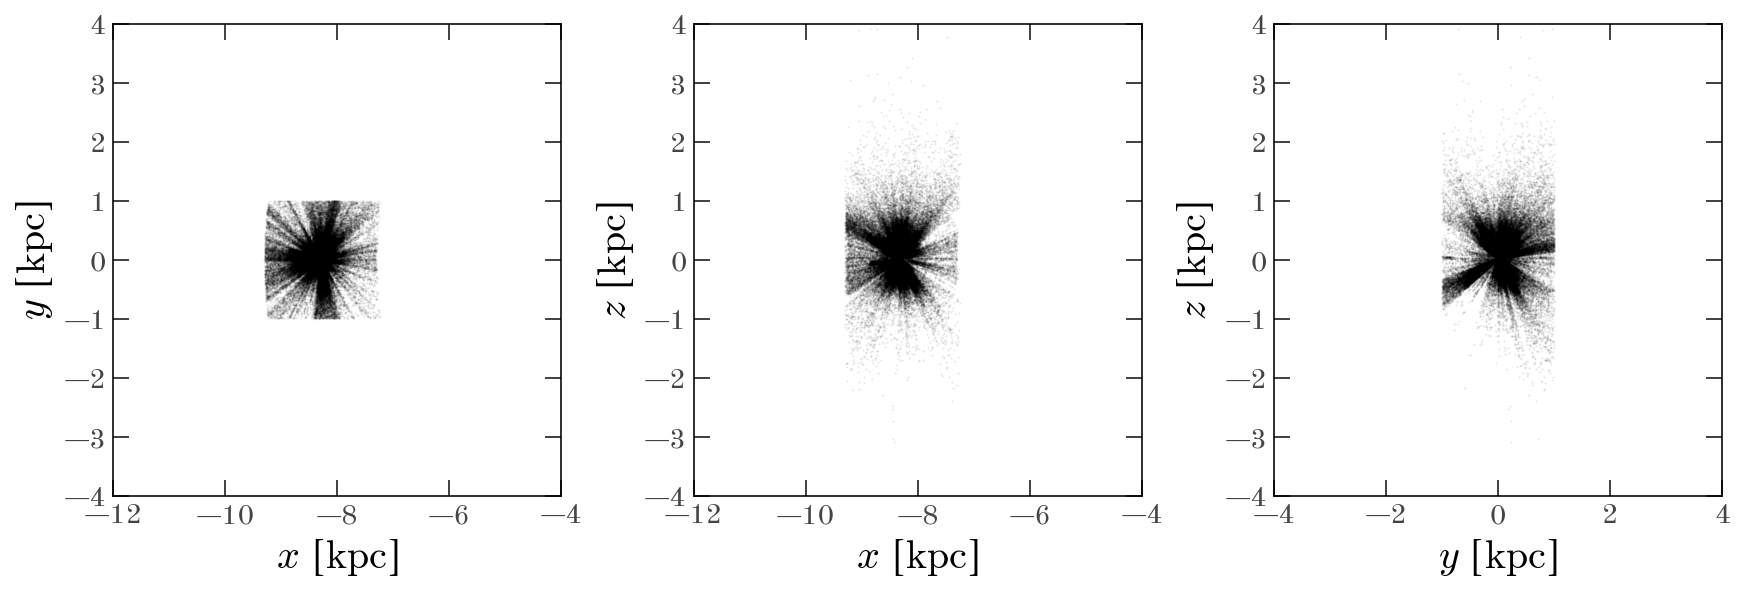

In [9]:
fig = w0[mask].plot(
    marker="o",
    mew=0,
    ms=1.0,
    alpha=0.1,
    plot_function=plt.plot,
    ls="none",
    units=u.kpc,
    auto_aspect=False,
)
fig.axes[0].set(xlim=(-12, -4), ylim=(-4, 4))
fig.axes[1].set(xlim=(-12, -4), ylim=(-4, 4))
fig.axes[2].set(xlim=(-4, 4), ylim=(-4, 4))

We are now ready to model the vertical kinematics of these stars. In this tutorial, we do this using the mean [Mg/Fe] abundance in bins of the vertical phase-space coordinates $z, v_z$.
As we show in Price-Whelan et al. 2024, moments of the abundance distribution satisfy a collisionless Boltzmann equation, so contours of constant element abundance moments (e.g., mean [Mg/Fe] abundance) should approximately trace contours of constant vertical action and therefore orbits.

To use our APOGEE–Gaia data, we therefore construct a binned version of the data: We bin the data into small pixels of the vertical phase-space, $z,v_z$, and compute the mean [Mg/Fe] abundance of stars in each pixel. We use a helper function in `torusimaging` to do this, which lets us specify bins with units attached. The number of bins we pick here is somewhat arbitrary and has to be set heuristically: We want to have enough stars in each bin to get a good estimate of the mean abundance, but not so many that the bins are too large and we lose information about the vertical structure. We use 81 bins in the vertical position and velocity, which correspond to bin sizes of about 30 pc and 0.9 km/s, respectively, for our choices of the maximum $z$ and $v_z$ values adopted below.

In [10]:
max_z = 1.2 * u.kpc
max_vz = 70 * u.km / u.s
bins = {
    "pos": np.linspace(-1, 1, 81) * max_z,
    "vel": np.linspace(-1, 1, 81) * max_vz,
}

In [11]:
sample_galcen = galcen[mask]

bdata = oti.data.get_binned_label(
    pos=sample_galcen.z.astype("f8"),
    vel=sample_galcen.v_z.astype("f8"),
    label=mgfe[mask],
    label_err=mgfe_err[mask],
    bins=bins,
    units=galactic,
    s_N_thresh=16,
)

Let's now visualize the binned data, both in terms of the number of stars in different locations of the phase space and in the mean [Mg/Fe] abundance:

Text(0, 0.5, '$z$ [$\\mathrm{kpc}$]')

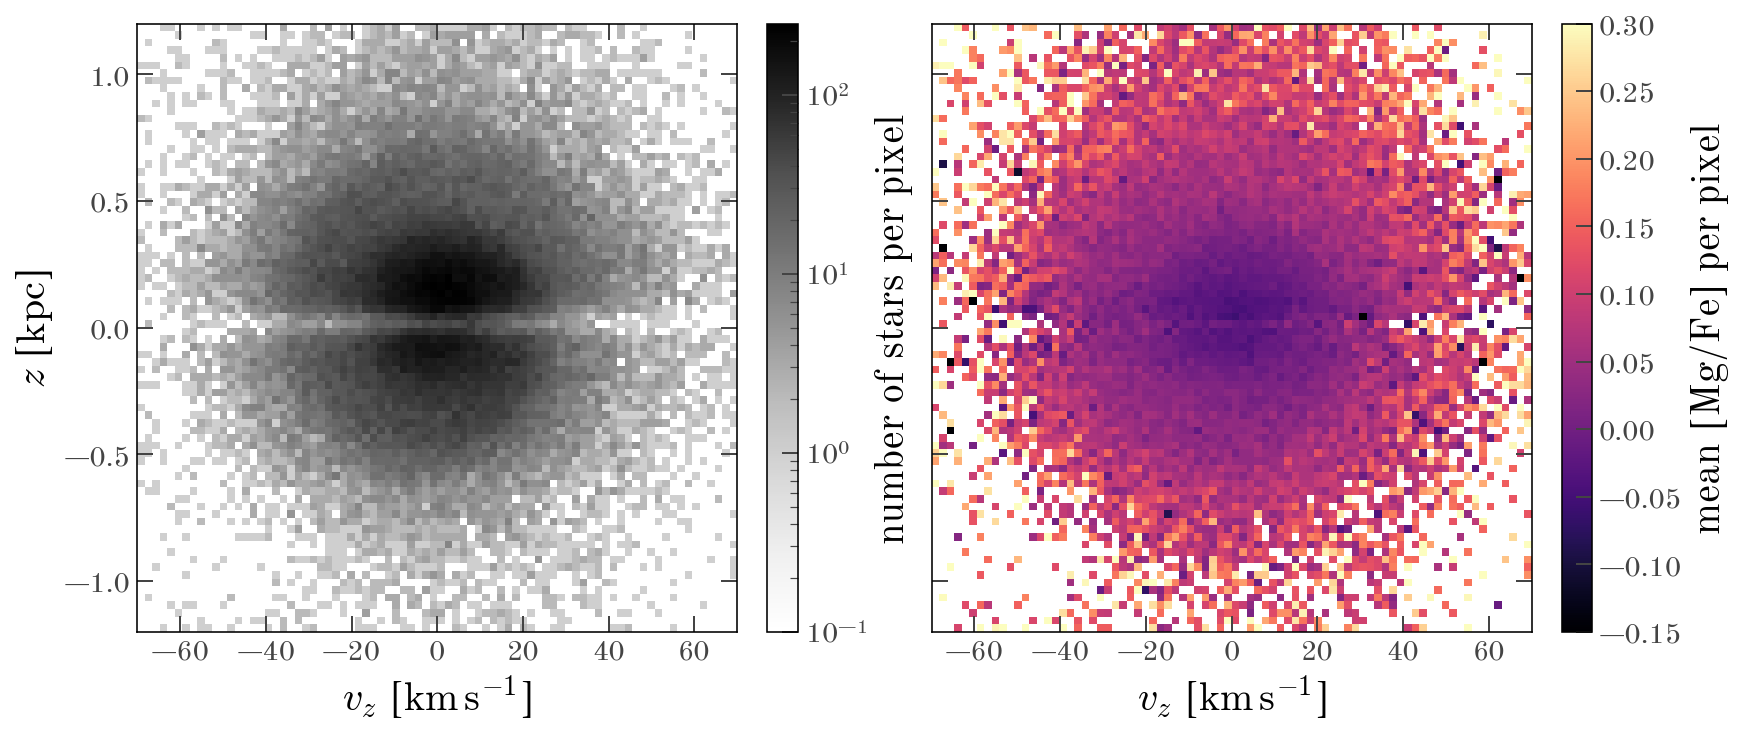

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

ax = axes[0]
cs = ax.pcolormesh(
    bdata["vel"].to_value(u.km / u.s),
    bdata["pos"].to_value(u.kpc),
    bdata["counts"],
    norm=mpl.colors.LogNorm(vmin=0.1),
    cmap="Greys",
)
cb = fig.colorbar(cs, ax=ax)
cb.set_label("number of stars per pixel")

ax = axes[1]
cs = ax.pcolormesh(
    bdata["vel"].to_value(u.km / u.s),
    bdata["pos"].to_value(u.kpc),
    bdata["label"],
    vmin=-0.15,
    vmax=0.3,
)
cb = fig.colorbar(cs, ax=ax)
cb.set_label("mean [Mg/Fe] per pixel")

for ax in axes:
    ax.set_xlabel(f"$v_z$ [{u.km/u.s:latex_inline}]")
axes[0].set_ylabel(f"$z$ [{u.kpc:latex_inline}]")

A number of things are apparent from these plots. For one, very near the galactic midplane ($z \sim 0$), our sample has very few stars, so the survey selection function here is clearly a strong function of $z$. Another thing apparent in the left panel is the prominent spiral feature (this is the [Gaia phase spiral](https://ui.adsabs.harvard.edu/abs/2018Natur.561..360A/abstract)). Despite the strong selection function in the number of stars, and the prominent spiral in the phase-space density, the mean [Mg/Fe] abundance in the right panel is relatively smooth in $z$ and $v_z$. This is the advantage of using moments of the stellar label distribution: They are much less sensitive to the survey selection function. In general, in the right panel, there is an overall smooth trend in that stars near $(z, v_z) \sim (0, 0)$ have lower [Mg/Fe] values than stars at larger $z$ and $v_z$. This trend is what we will exploit using `torusimaging` to measure the shapes of contours of mean abundance and, therefore, the shapes of orbits.

The Orbital Torus Imaging framework is very flexible and allows constructing models with arbitrary functions to control the $e_m$ functions and the dependence of the label moments on the phase-space coordinates (see Price-Whelan et al. 2024). In this case, we will use a specialized subclass of the `torusimaging.TorusImaging1D` class that is designed to treat all of these functions as spline functions: `torusimaging.TorusImaging1DSpline`. This class has an optional automatic initializer that determines the spline parameter bounds and some initial parameter values given data, which we will use here.

In [13]:
model, bounds, init_params = oti.TorusImaging1DSpline.auto_init(
    bdata,
    label_knots=4,
    e_knots={2: 8, 4: 4},
    label_l2_sigma=1.0,
    label_smooth_sigma=0.5,
    e_l2_sigmas={2: 1.0, 4: 1.0},
    e_smooth_sigmas={2: 0.5, 4: 0.5},
    dacc_strength=1e2,
    e_knots_spacing_power=0.5,
)

Here we will describe the various parameter choices made above:
- `label_knots` — The number of knots (4) to use for the quadratic spline function that controls the dependence of the label moments on the phase-space coordinates. 
- `e_knots` — The number of knots (8 and 4) to use for the quadratic spline functions that control the $e_2$ and $e_4$ Fourier amplitude functions. This is specified as a dictionary, where the keys are the $m$ orders of the functions, and the values are the number of knots to use for each function.
- `*_sigma` — These are smoothing parameters applied to the spline derivatives to lightly control the smoothness of the functions. These are implemented as Gaussian priors with the specified standard deviations (`sigma`).
- `dacc_strength=1e2` — This argument enables a strong prior (or regularization) on the spline functions that tries to enforce that the density be positive everywhere.
- `e_knots_spacing_power=0.5` — This argument spaces the knots in the $e_m$ functions uniformly in the square-root of the elliptical radius, which is a good choice for functions that increase rapidly near zero and are smoother for larger values, as we expect here.

The automatic initializer does not provide initial guesses for the spline knot parameters, so we will set these to some reasonable values by hand. The parameters that `torusimaging` optimizes over are the natural log of the derivative of the spline function at each knot, so we will set these to the same value for each knot, which makes linear functions:

In [14]:
init_params["e_params"][2]["vals"] = np.full_like(
    init_params["e_params"][2]["vals"], np.log(0.1 / model._label_knots.max())
)
init_params["e_params"][4]["vals"] = np.full_like(
    init_params["e_params"][4]["vals"], np.log(0.01 / model._label_knots.max())
)

Let's visualize the data, the initial model, and the residuals between the data and the initial model:

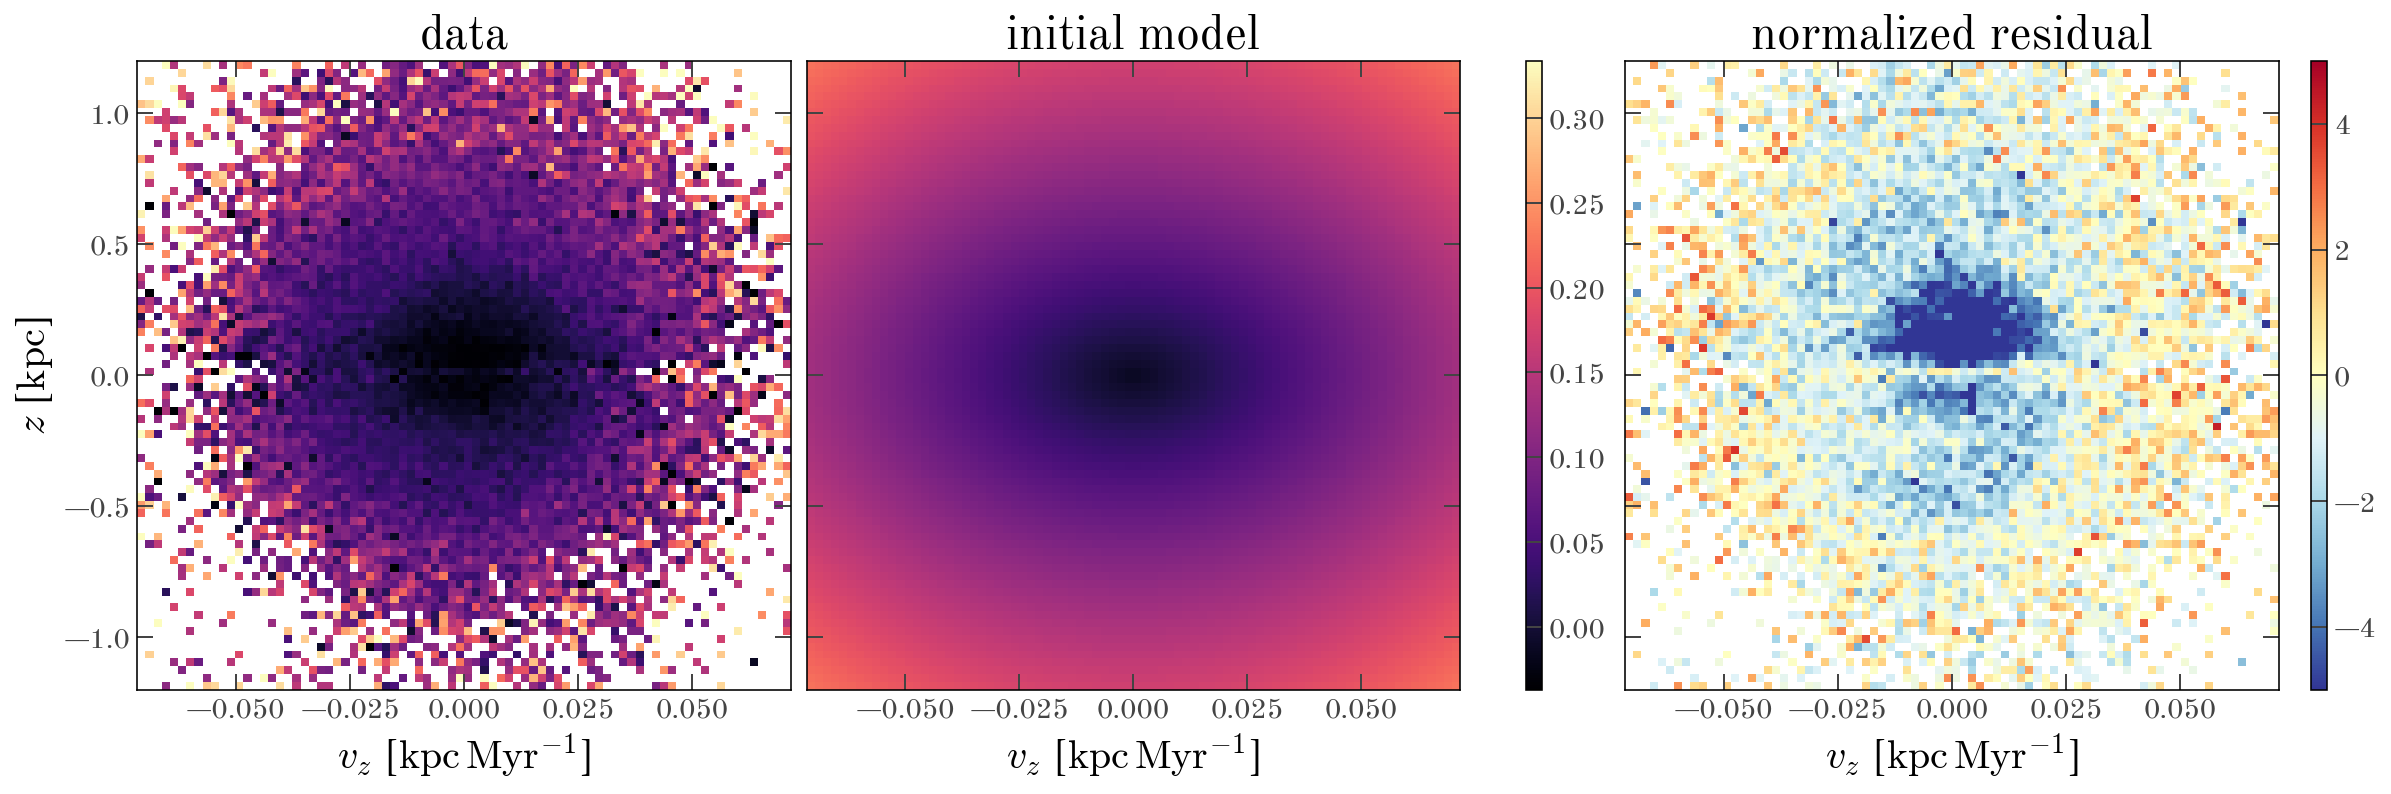

In [15]:
fig, axes = oti.plot.plot_data_models_residual(
    bdata,
    model,
    init_params,
    vlim_residual=5,
    residual_normalization=bdata["label_err"],
)
_ = axes[1].set_title("initial model")

Our initial guess is clearly not a good fit to the data, but it is a good starting point for the optimization. We now optimize the model parameters using `jaxopt`.

We now create a new dictionary of the binned data, but here we filter out any pixels with 0 stars or invalid mean abundance values:

In [16]:
bdata_clean = dict(
    pos=bdata["pos"],
    vel=bdata["vel"],
    label=bdata["label"],
    label_err=bdata["label_err"],
)
bdata_mask = (
    np.isfinite(bdata["label"])
    & np.isfinite(bdata["label_err"])
    & (bdata["label_err"] > 0)
)
bdata_clean = {k: v[bdata_mask] for k, v in bdata_clean.items()}

We now start the optimizer from our initial parameter values:

In [17]:
res = model.optimize(init_params, objective="gaussian", bounds=bounds, **bdata_clean)
res.state.success, res.state.iter_num

(True, 1466)

The optimizer succeeded! Let's now visualize the optimized model compared to the data:

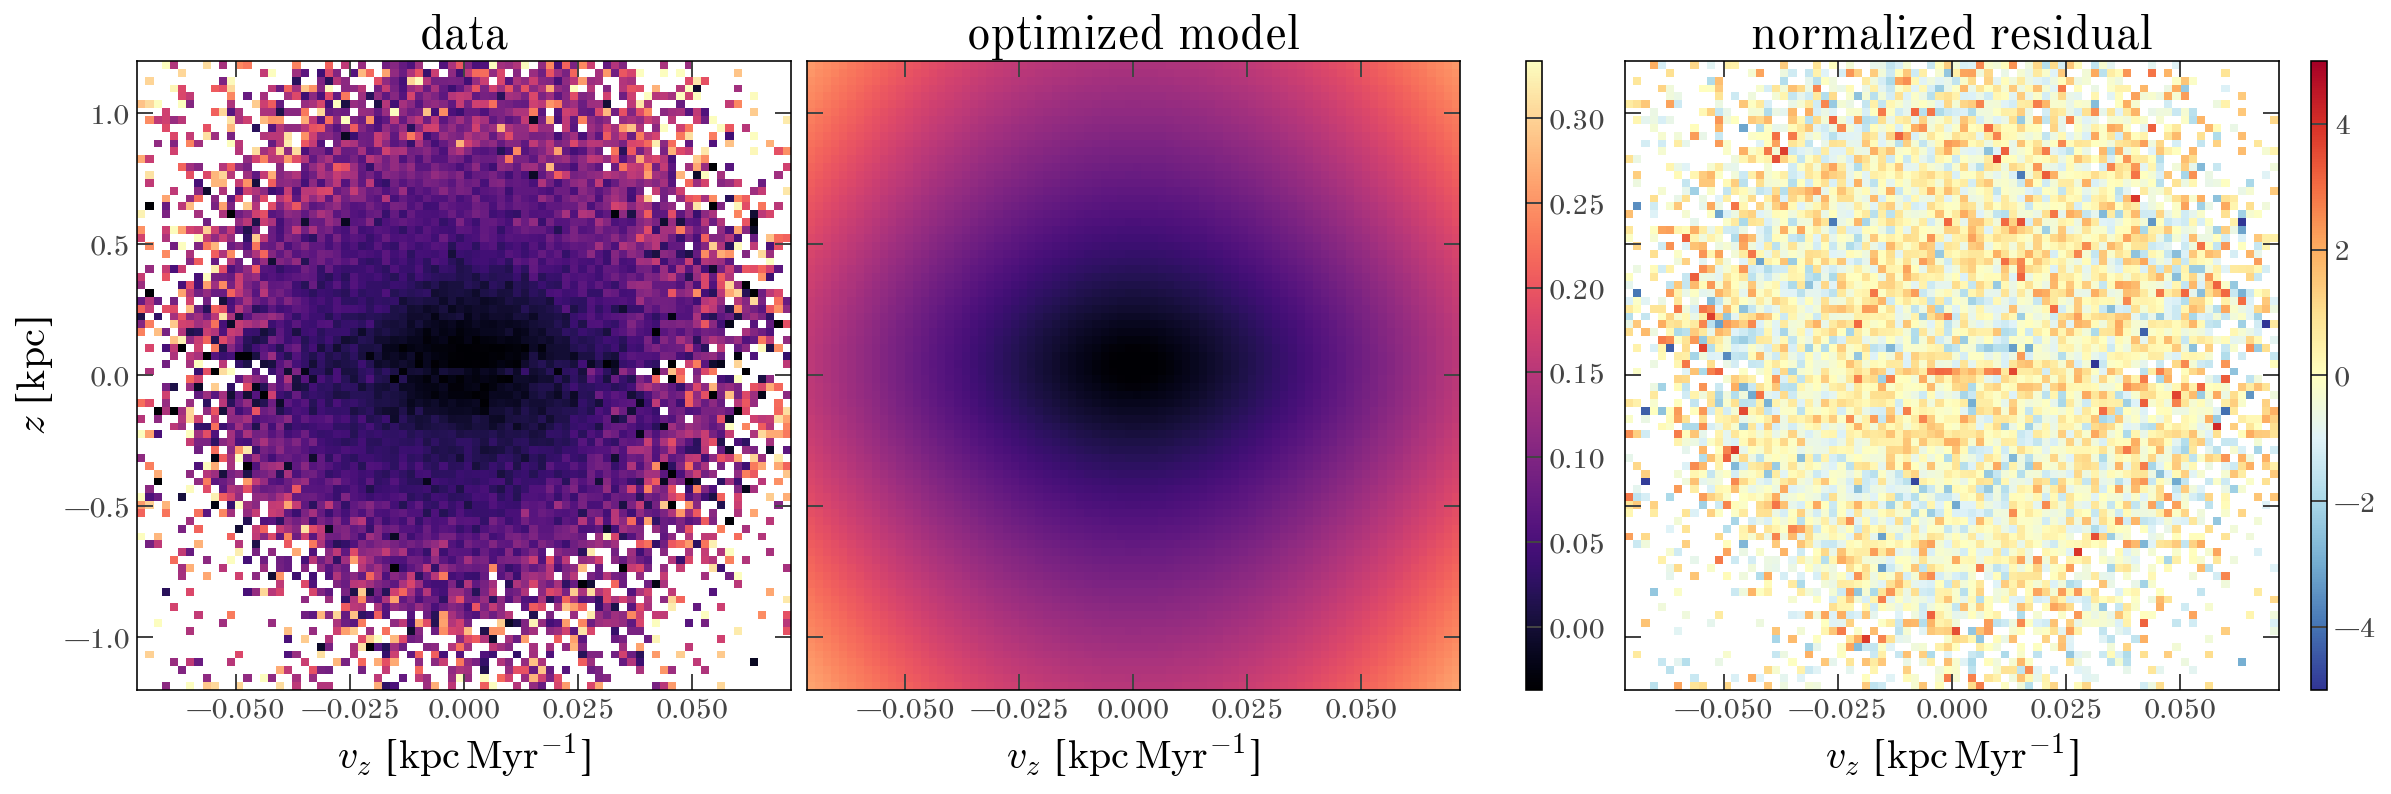

In [18]:
fig, axes = oti.plot.plot_data_models_residual(
    bdata, model, res.params, vlim_residual=5, residual_normalization=bdata["label_err"]
)
_ = axes[1].set_title("optimized model")

This is a much better representation of the data, and the residuals are significantly smaller than at our initial parameter values.

We can also visualize the spline functions that control the $e_m$ coefficient functions and the label function:

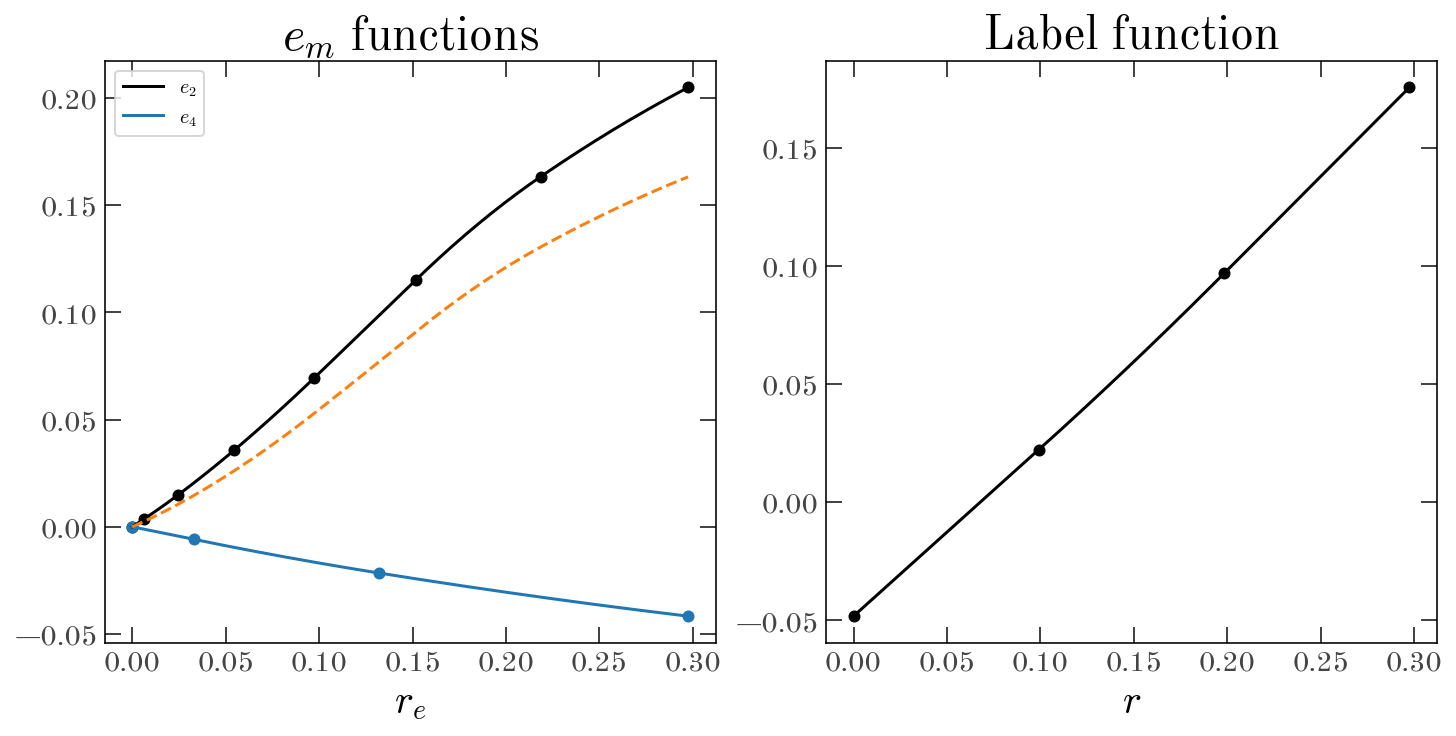

In [19]:
_ = oti.plot.plot_spline_functions(model, res.params)

We now use MCMC to quantify the uncertainties on the model parameters and derived quantities.

With the optimized parameter values, we start running MCMC to sample the posterior distribution over the model parameters. We use the ``blackjax`` package under the hood to run the MCMC, which uses the [NUTS](https://arxiv.org/abs/1111.4246) sampler. We run the sampler for 2000 steps to tune the sampler, and then another 2000 steps to generate MCMC samples:

In [20]:
mcmc_state, mcmc_params = model.mcmc_run_label(
    bdata,
    p0=res.params,
    bounds=bounds,
    rng_seed=42,
    num_warmup=2000,
    num_steps=2000,
)

From the returned `HMCState` object and the MCMC samples, we can pull out the maximum a posteriori (MAP) parameter values to visualize the inferred model:

In [21]:
MAP_params = mcmc_params[mcmc_state.logdensity.argmax()]

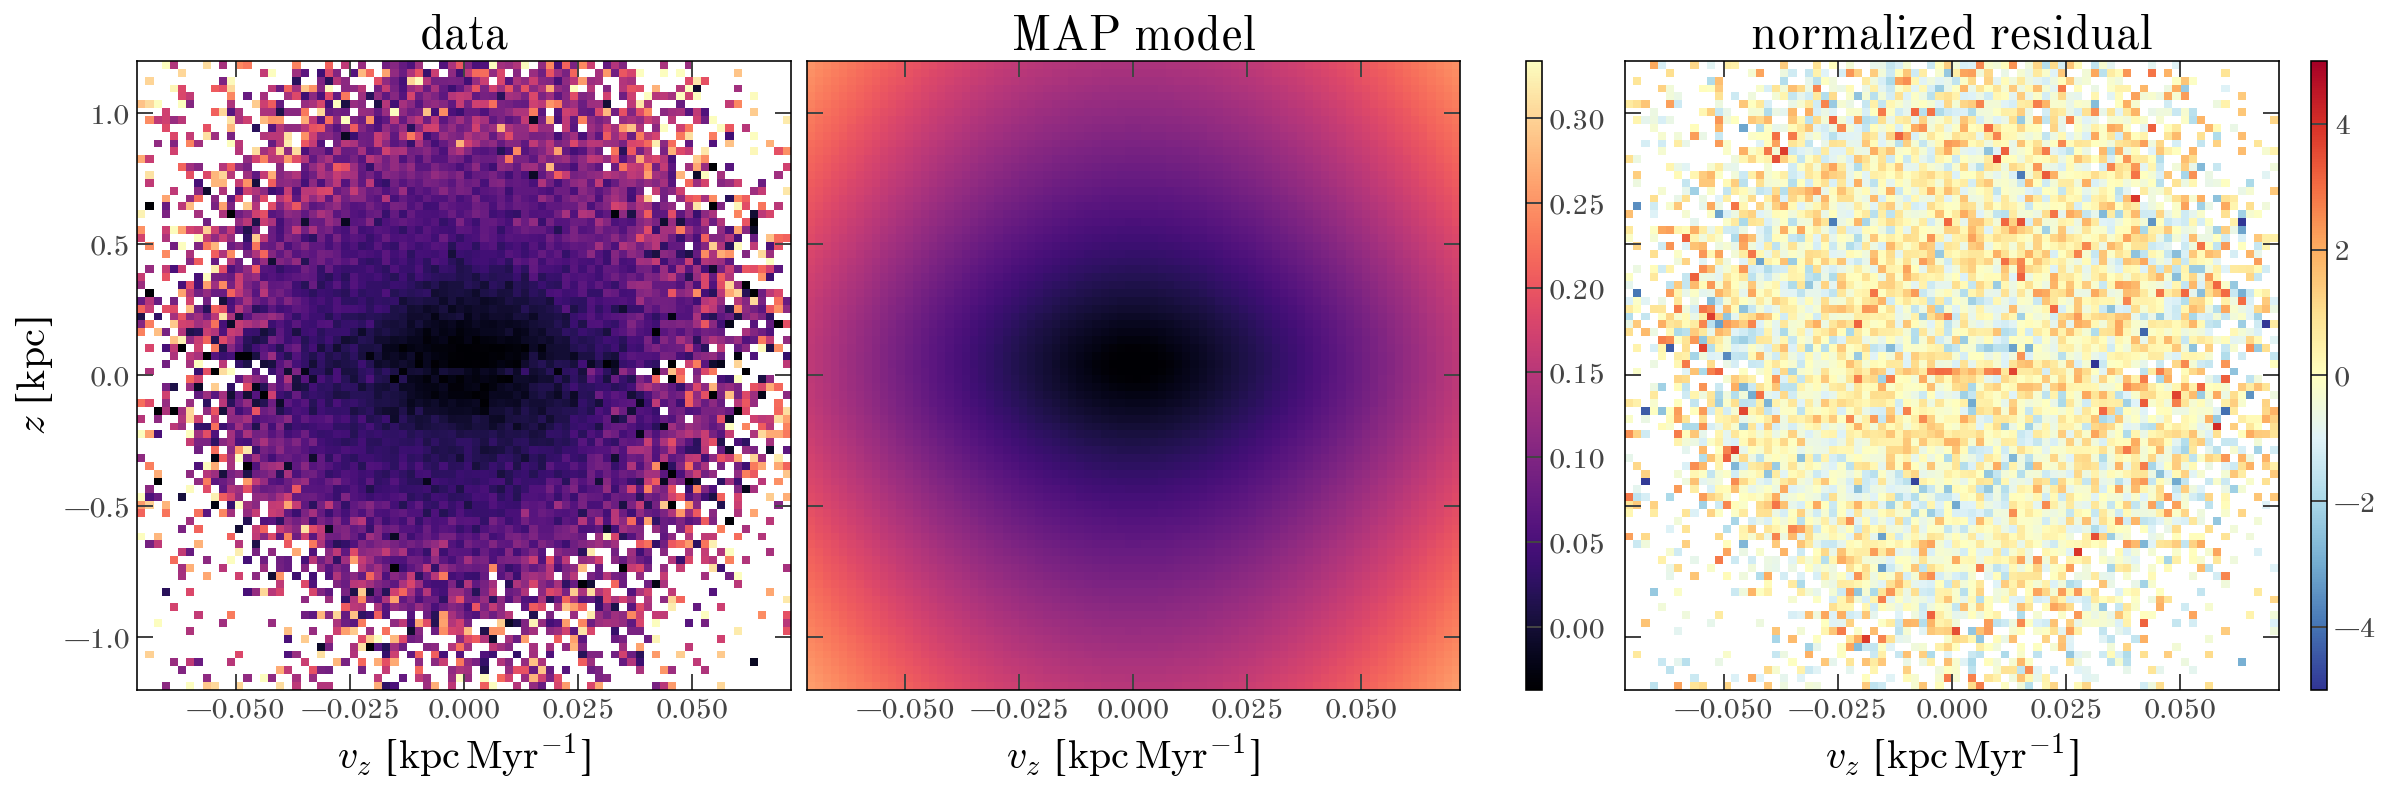

In [22]:
fig, axes = oti.plot.plot_data_models_residual(
    bdata, model, MAP_params, vlim_residual=5, residual_normalization=bdata["label_err"]
)
_ = axes[1].set_title("MAP model")

The MAP model captures the dependence of the mean [Mg/Fe] abundance on $z$ and $v_z$ well, as indicated by the small residuals in the right panel of the figure above. Below, we plot the inferred vertical acceleration profile, $a_z(z)$, and the implied vertical density profile from its derivative. We show these profiles for the MAP model in black, and for 128 MCMC samples as the gray lines. The over-plotted green line in the density plot shows, for comparison, an exponential profile with a scale height of 300 pc.

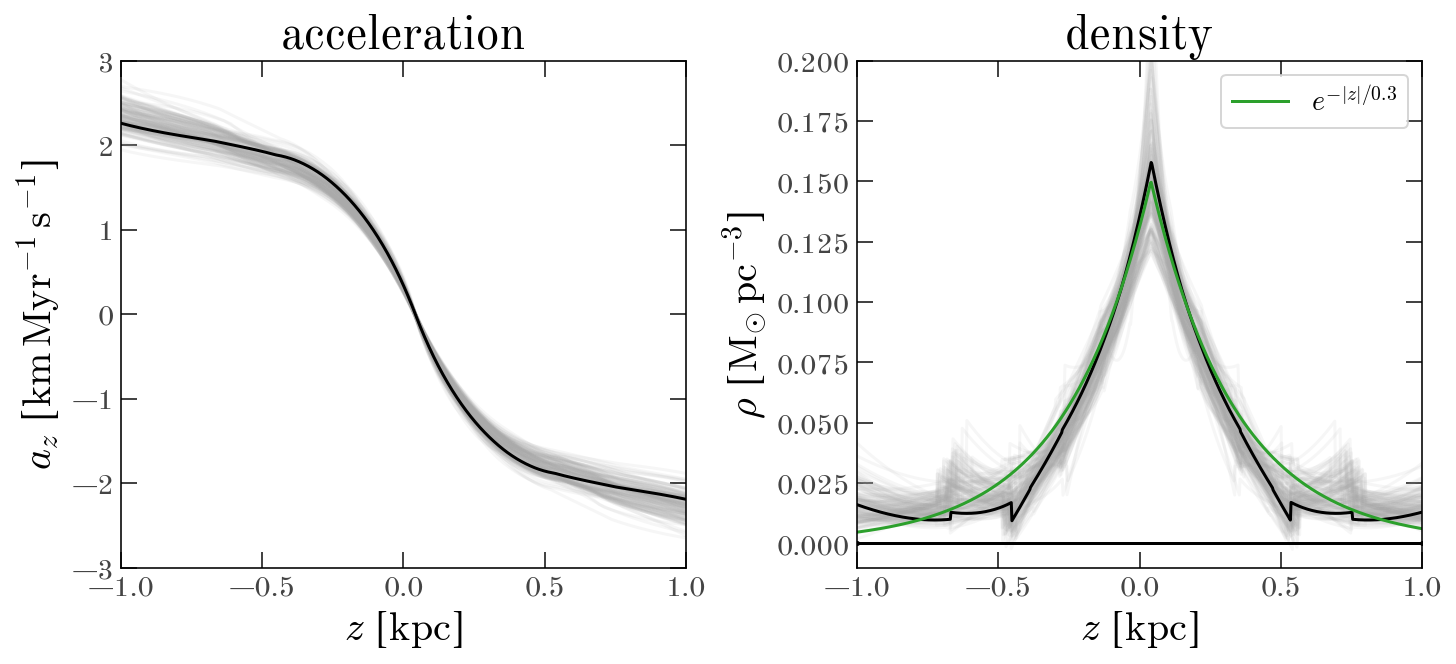

In [23]:
z_grid = np.linspace(-1, 1, 1024) * max_z
a_unit = u.km / u.s / u.Myr
dens_unit = u.Msun / u.pc**3

fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), layout="constrained", sharex=True)

mcmc_style = dict(marker="", alpha=0.1, color="#aaaaaa")
for pp in mcmc_params[-128:]:
    az = model.get_acceleration(z_grid, pp)
    daz_dz = model.get_acceleration_deriv(z_grid, pp)
    dens = -daz_dz / (4 * np.pi * G)
    axes[0].plot(z_grid.value, az.to_value(a_unit), **mcmc_style)
    axes[1].plot(z_grid.value, dens.to_value(dens_unit), **mcmc_style)

pp = MAP_params
az = model.get_acceleration(z_grid, pp)
daz_dz = model.get_acceleration_deriv(z_grid, pp)
dens = -daz_dz / (4 * np.pi * G)

MAP_style = dict(marker="", color="k")
axes[0].plot(z_grid.value, az.to_value(a_unit), **MAP_style)
axes[1].plot(z_grid.value, dens.to_value(dens_unit), **MAP_style)

with u.set_enabled_equivalencies(u.dimensionless_angles()):
    comp = 0.15 * np.exp(-np.abs(z_grid - res.params["pos0"] * u.kpc) / (0.3 * u.kpc))
axes[1].plot(z_grid.value, comp, marker="", color="tab:green", label="$e^{-|z|/0.3}$")

axes[1].axhline(0.0)
axes[0].set(
    xlim=(-1, 1),
    ylim=(-3, 3),
    ylabel=f"$a_z$ [{a_unit:latex_inline}]",
    title="acceleration",
)
axes[1].set(
    ylim=(-0.01, 0.2), ylabel=f"$\\rho$ [{dens_unit:latex_inline}]", title="density"
)
axes[1].legend(loc="upper right", fontsize=14)

for ax in axes:
    ax.set_xlabel(f"$z$ [{u.kpc:latex_inline}]")

We can also use the MCMC samples to compute uncertainties on the model parameters and derived quantities. For example, we measure the vertical solar position and velocity relative to the fiducial Galactocentric coordinate frame:

In [24]:
pos0_samples = (np.array([x["pos0"] for x in mcmc_params]) * u.kpc).to_value(u.pc)
vel0_samples = (np.array([x["vel0"] for x in mcmc_params]) *u.kpc/u.Myr).to_value(u.km/u.s)
print(
    f"Vertical solar position, relative to fiducial frame: {np.mean(pos0_samples):.1f} "
    f"+/- {np.std(pos0_samples):.1f} pc"
)
print(
    f"Vertical solar velocity, relative to fiducial frame: {np.mean(vel0_samples):.1f} "
    f"+/- {np.std(vel0_samples):.1f} km/s"
)

Vertical solar position, relative to fiducial frame: 40.4 +/- 1.8 pc
Vertical solar velocity, relative to fiducial frame: 0.3 +/- 0.2 km/s


As a final demonstration, we now use the model to compute actions and angles for the stars in the sample. We will compute the actions and angles for the MAP parameters:

In [25]:
aaf_oti = model.compute_action_angle(
    sample_galcen.z, sample_galcen.v_z, params=MAP_params
)

As a comparison, we will also compute actions and angles for a standard axisymmetric model of the Milky Way's mass distribution (from Hunt et al. 2022). We will use [Agama](https://github.com/GalacticDynamics-Oxford/Agama) to compute the comparison actions and angles:

In [26]:
import agama
agama.setUnits(mass=u.Msun, length=u.kpc, time=u.Myr)

mw = gp.MilkyWayPotential2022()
agama_pot = mw.as_interop("agama")
af = agama.ActionFinder(agama_pot)

In [27]:
aaf_agama = af(w0[mask].w(galactic).T, angles=True)
aaf_agama = {
    "J": aaf_agama[0][:, 1] * galactic["kinematic viscosity"],
    "theta": aaf_agama[1][:, 1] * galactic["angle"],
    "Omega": aaf_agama[2][:, 1] * galactic["angular frequency"],
}

Let's see how the `torusimaging` actions, frequencies, and angles compare to those computed with Agama:

[(0.0, 6.283185307179586), (0.0, 6.283185307179586)]

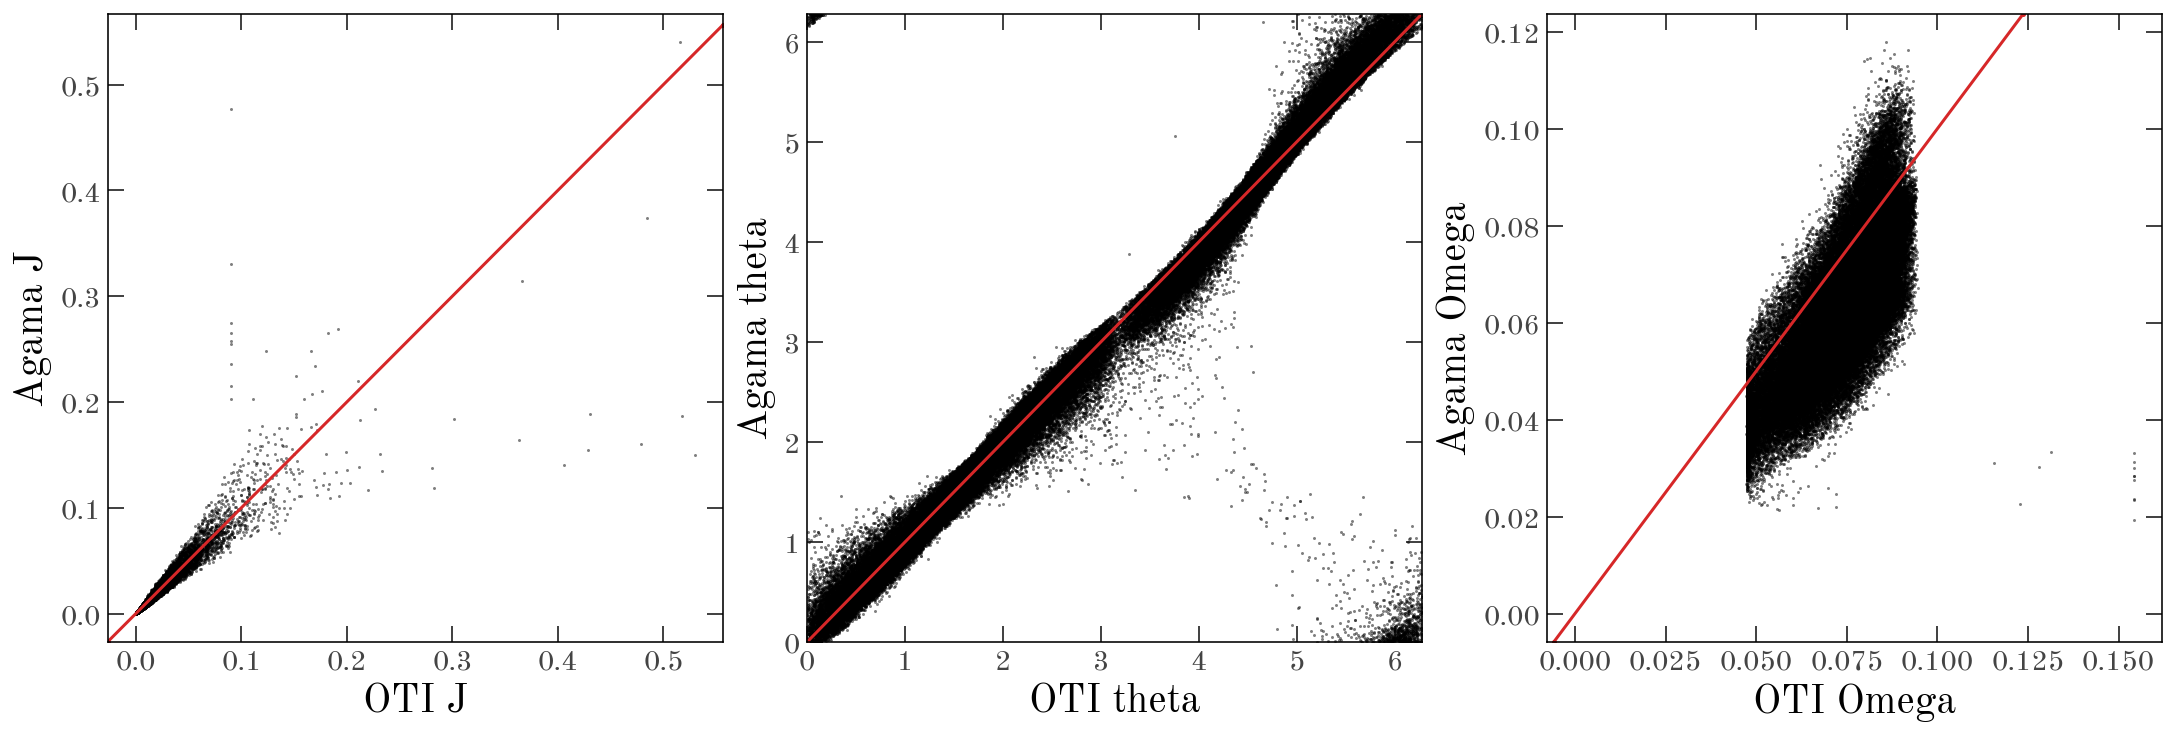

In [31]:
style = dict(ls="none", marker="o", alpha=0.5, ms=1.5)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for name, ax in zip(["J", "theta", "Omega"], axes):
    if name == "theta":
        ax.plot(
            aaf_oti[name].value % (2*np.pi), aaf_agama[name].value % (2*np.pi), **style
        )
    else:
        ax.plot(aaf_oti[name], aaf_agama[name], **style)
    ax.set(xlabel=f"OTI {name}", ylabel=f"Agama {name}")
    ax.axline((0, 0), slope=1, color='tab:red')
axes[1].set(xlim=(0, 2*np.pi), ylim=(0, 2*np.pi))